In [173]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xinwangcs/stressor-cause-of-mental-health-problem-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\xinwangcs\stressor-cause-of-mental-health-problem-dataset\versions\1


In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
FILES = []
for file in os.listdir(path):
    if file.endswith(".json"):
        PATH = os.path.join(path, file)
        FILES.append(PATH )
print("Files in dataset:", FILES)



Files in dataset: ['C:\\Users\\user\\.cache\\kagglehub\\datasets\\xinwangcs\\stressor-cause-of-mental-health-problem-dataset\\versions\\1\\stressor_test.json', 'C:\\Users\\user\\.cache\\kagglehub\\datasets\\xinwangcs\\stressor-cause-of-mental-health-problem-dataset\\versions\\1\\stressor_train.json']


In [175]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [176]:
import json

def load_data2dataframe(file):
    """
    讀取 JSON 文件並將其轉換為 Pandas DataFrame。
    參數:
        file (str): 檔案路徑。

    錯誤回報:
        ValueError: 如果在資料集目錄中找不到 JSON 檔案。
        ValueError: 如果指定的 JSON 檔案不存在。
        
    回傳:
        pd.DataFrame: 包含文本、壓力源類別、壓力源詞和時間間隔的 DataFrame。
    """
    if not FILES:
        raise ValueError("No JSON files found in the dataset directory.")
    if not os.path.exists(file):
        raise ValueError(f"File '{file}' does not exist.")
    with open(file, encoding="utf-8") as f:
        data = json.load(f)
        if not isinstance(data, list):
            raise ValueError(f"Expected a list in JSON file, got {type(data)}")
        temp = []
        for item in data:
            #print(item)
            TEXT = item["text"]
            INTERVAL = item["interval"]
            try:
                STRESSOR_class = item["labels"][0][0]
                STRESSOR_WORD = item["labels"][0][4]
            except IndexError:
                STRESSOR_class = np.nan
                STRESSOR_WORD = np.nan
            temp.append((TEXT, STRESSOR_class, STRESSOR_WORD, INTERVAL))

    # Convert list of tuples to DataFrame with column names
    return pd.DataFrame(temp, columns=["text", "stressor_class", "stressor_word", "interval"])

# Ensure each element is a DataFrame before concatenation
dataframes = [load_data2dataframe(f) for f in FILES]
df = pd.concat(dataframes, ignore_index=True)
df.head()

,text,stressor_class,stressor_word,interval
0,Why are there always trivial matters in life t...,T1,financial,8
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8
2,"In the coming March, my work pressure will be ...",T1,work,8
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8


In [177]:
df.dropna(inplace=True)
df.isna().sum()

text              0
stressor_class    0
stressor_word     0
interval          0
dtype: int64

In [178]:
df_copy = df.copy()

In [179]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [180]:
import spacy

nlp = spacy.load("en_core_web_sm")

def normalize_spacy(text):
    doc = nlp(text.lower())
    lemmatized = []
    for token in doc:
        if token.is_punct or token.is_space or token.is_stop:
            continue
        lemma = token.lemma_
        lemmatized.append(lemma)
    return lemmatized

print(normalize_spacy("everyone myself others I around me, urged to marry the cats and dogs"))


['urge', 'marry', 'cat', 'dog']


In [181]:
from gensim import corpora
from gensim.models import TfidfModel
texts = [normalize_spacy(word) for word in df_copy["stressor_word"]]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# TFiDF = TfidfModel(corpus)
# corpus_TFiDF = [TFiDF[doc] for doc in corpus]

In [182]:
empty_indices = [i for i, doc in enumerate(corpus) if not doc]
print(empty_indices)

[22, 59, 103, 113, 145, 165, 166, 223, 225, 236, 335, 374, 416, 419, 455, 463, 492, 512, 526, 540, 614, 657, 753, 798, 857, 917, 920, 933, 992, 1002, 1059, 1077, 1086, 1150, 1167, 1172, 1205, 1252, 1256, 1356, 1442, 1451, 1513, 1568, 1623, 1677, 1680, 1685, 1798, 1866, 1893, 1902, 1958, 1969, 2013, 2089, 2155, 2173, 2180, 2182, 2230, 2238, 2258, 2264, 2288, 2373, 2414, 2427, 2529, 2692, 2715, 2720, 2745, 2756, 2764, 2790, 2875, 2925, 3085, 3089, 3144, 3162, 3189, 3240, 3352, 3417, 3444, 3465, 3472, 3496, 3505, 3545, 3630, 3743, 3827, 3844, 3876, 3902, 3971, 3983]


In [183]:
# 刪除 corpus_TFiDF 中 empty_indices 對應的元素
corpus= [doc for i, doc in enumerate(corpus) if i not in empty_indices]

In [184]:
try:
    df_copy.drop(empty_indices, inplace=True)
except:
    pass

計算最佳主題數
---

In [185]:
# from gensim.models import CoherenceModel
# from gensim.models.ldamodel import LdaModel
# def compute_coherence_values(dictionary, corpus, texts, start=2, limit=10):
#     coherence_values = []
#     for num_topics in range(start, limit+1):
#         model = LdaModel(
#                             corpus=corpus, 
#                             id2word=dictionary,
#                             num_topics=num_topics, 
#                             alpha='auto',
#                             eta='auto',
#                             passes=10
#                     )
#         coherence_model = CoherenceModel(
#                                             model=model, 
#                                             texts=texts, 
#                                             dictionary=dictionary, 
#                                             coherence='c_v'
#                                     )
#         coherence_values.append(coherence_model.get_coherence())
#     return coherence_values
# temp = []
# for i in range(1,11):
#     coherence_values = compute_coherence_values(
#                                                 dictionary , 
#                                                 corpus,
#                                                 texts,
#                                                 start=2,
#                                                 limit=10
#                                             )
#     temp.append(coherence_values)

In [186]:
# print([np.argmax(scores)+2 for scores in temp])

In [187]:
# scores = np.mean(temp, axis=0)
# x = range(2,11)
# plt.plot(x, scores)
# plt.title("Optimal Number of Topics")
# plt.grid(axis="x" , linestyle='--')
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score")
# plt.show()

模型建立-進行主題分群
---

In [188]:
from gensim.models.ldamodel import LdaModel
# 建立 LDA 模型
lda_model = LdaModel(corpus=corpus, 
                     id2word=dictionary, 
                     num_topics=3, # (3 or 4)
                     passes=50,
                     random_state=42
                )

# 取得每筆資料的主題分佈
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# 取最大主題編號作為群標籤
topic_labels = [max(dist, key=lambda x: x[1])[0] for dist in topic_distributions]

In [189]:
lda_model.print_topics(num_words=10)

[(0,
  '0.047*"job" + 0.033*"entrance" + 0.026*"school" + 0.026*"graduate" + 0.025*"money" + 0.025*"year" + 0.022*"examination" + 0.022*"new" + 0.016*"high" + 0.016*"paper"'),
 (1,
  '0.071*"exam" + 0.031*"family" + 0.026*"home" + 0.026*"parent" + 0.016*"academic" + 0.015*"economic" + 0.013*"social" + 0.013*"sister" + 0.012*"friend" + 0.012*"overtime"'),
 (2,
  '0.248*"work" + 0.123*"life" + 0.046*"study" + 0.029*"school" + 0.023*"mom" + 0.022*"start" + 0.015*"go" + 0.013*"marry" + 0.013*"peer" + 0.010*"urge"')]

In [190]:
df_copy["topic"] = topic_labels
df_copy.head(10)

,text,stressor_class,stressor_word,interval,topic
0,Why are there always trivial matters in life t...,T1,financial,8,1
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8,2
2,"In the coming March, my work pressure will be ...",T1,work,8,2
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8,0
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8,0
5,Staying up late is irreparable damage. I've st...,T1,learn,8,0
6,Watching decompressing videos on Douyin increa...,T1,decompressing videos,8,2
7,The pressure from scrolling through Xiaohongsh...,T1,Xiaohongshu,8,2
8,I'm out of money... the baby clothing store is...,T1,baby clothing store,8,1
9,"I am currently feeling the pressure from ez, a...",T1,ez,8,2


In [191]:
df_copy.dropna(inplace=True)
df_copy.isna().sum()

text              0
stressor_class    0
stressor_word     0
interval          0
topic             0
dtype: int64

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X = df_copy["text"]
y = df_copy["topic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , stratify=y)


In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
texts = [normalize_spacy(word) for word in X]
dictionary = Dictionary(texts)

X_train_tokens = [normalize_spacy(text) for text in X_train]
X_test_tokens = [normalize_spacy(text) for text in X_test]

X_train_vectorized = [dictionary.doc2bow(text) for text in X_train_tokens]
X_test_vectorized = [dictionary.doc2bow(text) for text in X_test_tokens]


tfidf_model = TfidfModel(X_train_vectorized)
X_train_tfidf = [tfidf_model[doc] for doc in X_train_vectorized]
X_test_tfidf = [tfidf_model[doc] for doc in X_test_vectorized]


In [194]:
from gensim import matutils
import numpy as np

# 將稀疏向量轉成稠密矩陣
def bow_to_dense(corpus, dictionary):
    return np.array([
        matutils.corpus2dense([bow], num_terms=len(dictionary)).T[0]
        for bow in corpus
    ])

# X_train_dense = bow_to_dense(X_train_vectorized, dictionary)
# X_test_dense = bow_to_dense(X_test_vectorized, dictionary)

X_train_dense = bow_to_dense(X_train_tfidf, dictionary)
X_test_dense = bow_to_dense(X_test_tfidf, dictionary)

X_train_vectorized = X_train_dense
X_test_vectorized = X_test_dense

# 模型比對


linear-SVC
---

In [195]:
from sklearn.svm import LinearSVC
SVC_model = LinearSVC(
                        penalty="l1" ,
                        class_weight="balanced",
                        random_state=42
                    )
SVC_model.fit(X_train_vectorized, y_train)  
y_pred = SVC_model.predict(X_test_vectorized)  
print(SVC_model.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.6267696267696268
              precision    recall  f1-score   support

           0       0.53      0.55      0.54       202
           1       0.59      0.55      0.57       231
           2       0.71      0.72      0.71       344

    accuracy                           0.63       777
   macro avg       0.61      0.61      0.61       777
weighted avg       0.63      0.63      0.63       777



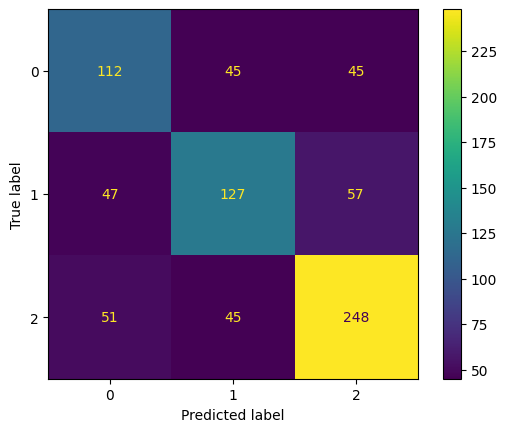

In [196]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(SVC_model, X_test_vectorized, y_test)
plt.show()

ComplementNB
---

In [197]:
from sklearn.naive_bayes import MultinomialNB ,ComplementNB
NB = ComplementNB()
NB.fit(X_train_vectorized, y_train)  
y_pred = NB.predict(X_test_vectorized)  
print(NB.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.5624195624195624
              precision    recall  f1-score   support

           0       0.48      0.42      0.45       202
           1       0.56      0.43      0.48       231
           2       0.60      0.74      0.66       344

    accuracy                           0.56       777
   macro avg       0.55      0.53      0.53       777
weighted avg       0.56      0.56      0.55       777



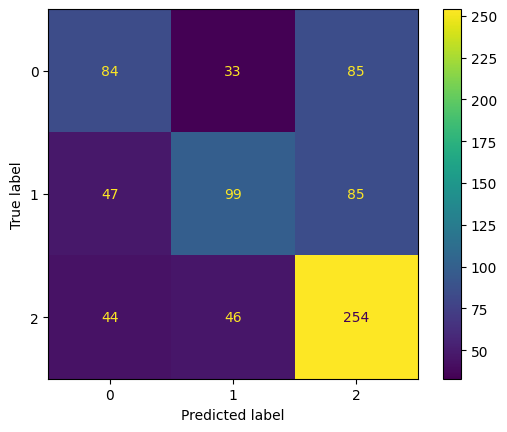

In [198]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(NB, X_test_vectorized, y_test)
plt.show()

RandomForestClassifier
---

In [199]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(class_weight="balanced")
RF.fit(X_train_vectorized, y_train)  
y_pred = RF.predict(X_test_vectorized)  
print(RF.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.6203346203346203
              precision    recall  f1-score   support

           0       0.60      0.45      0.51       202
           1       0.54      0.55      0.55       231
           2       0.68      0.76      0.72       344

    accuracy                           0.62       777
   macro avg       0.61      0.59      0.59       777
weighted avg       0.62      0.62      0.61       777



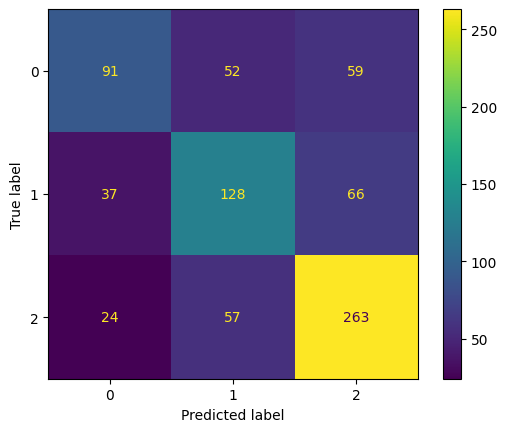

In [200]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(RF, X_test_vectorized, y_test)
plt.show()

LogisticRegression
---

In [201]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(class_weight="balanced")
LR.fit(X_train_vectorized, y_train)  
y_pred = LR.predict(X_test_vectorized)  
print(LR.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.6190476190476191
              precision    recall  f1-score   support

           0       0.53      0.59      0.56       202
           1       0.57      0.56      0.56       231
           2       0.72      0.67      0.70       344

    accuracy                           0.62       777
   macro avg       0.61      0.61      0.61       777
weighted avg       0.62      0.62      0.62       777



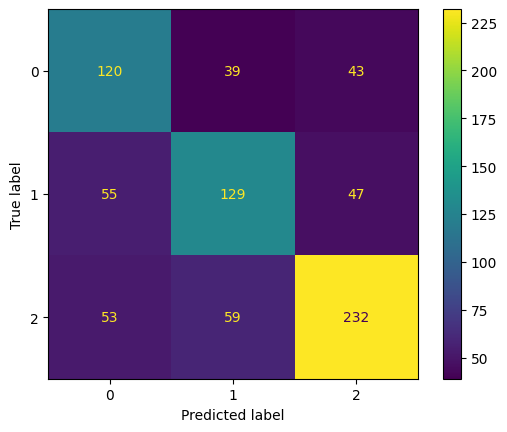

In [202]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(LR, X_test_vectorized, y_test)
plt.show()

SGDClassifier
---

In [203]:
from sklearn.linear_model import SGDClassifier 
SGD = SGDClassifier(
                    penalty="elasticnet", 
                    class_weight="balanced",
                    random_state=42 
                )
SGD.fit(X_train_vectorized, y_train)  
y_pred = SGD.predict(X_test_vectorized)  
print(SGD.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.5971685971685972
              precision    recall  f1-score   support

           0       0.51      0.54      0.53       202
           1       0.57      0.51      0.53       231
           2       0.67      0.69      0.68       344

    accuracy                           0.60       777
   macro avg       0.58      0.58      0.58       777
weighted avg       0.60      0.60      0.60       777



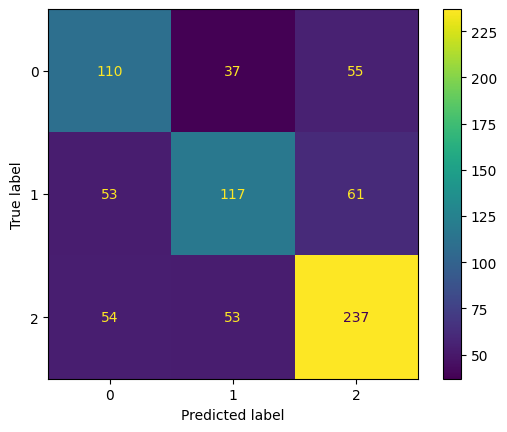

In [204]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(SGD, X_test_vectorized, y_test)
plt.show()

交叉驗證-1
---

In [205]:
from sklearn.model_selection import cross_val_score

print("NB : ",cross_val_score(NB, X_test_vectorized, y_test, cv=5).mean())
print("RF : ",cross_val_score(RF, X_test_vectorized, y_test, cv=5).mean())
print("LR : " , cross_val_score(LR, X_test_vectorized, y_test, cv=5).mean())
print("SVC : ",cross_val_score(SVC_model, X_test_vectorized, y_test, cv=5).mean())
print("SGD : ",cross_val_score(SGD, X_test_vectorized, y_test, cv=5).mean())

NB :  0.5225144747725393
RF :  0.5379321753515302
LR :  0.5443258891645988
SVC :  0.5713813068651777
SGD :  0.5147559966914805


# 超參數搜尋

linear-svc
---

In [210]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

svc_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [1, 2,3,4],
    'class_weight': ['balanced'],
    'max_iter': [1000]
}

svc_model = LinearSVC(random_state=42)
grid_svc = GridSearchCV(svc_model, svc_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train_vectorized, y_train)

print(grid_svc.best_score_)
print(grid_svc.best_params_)

0.6036006648337139
{'C': 1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1'}


In [211]:
print(classification_report(y_test, grid_svc.predict(X_test_vectorized)))

              precision    recall  f1-score   support

           0       0.53      0.55      0.54       202
           1       0.59      0.55      0.57       231
           2       0.71      0.72      0.71       344

    accuracy                           0.63       777
   macro avg       0.61      0.61      0.61       777
weighted avg       0.63      0.63      0.63       777



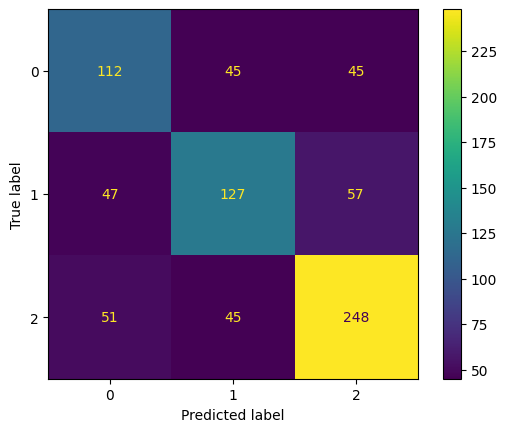

In [212]:
ConfusionMatrixDisplay.from_estimator(grid_svc.best_estimator_, X_test_vectorized, y_test)
plt.show()

logistic-regression
---

In [213]:
from sklearn.linear_model import LogisticRegression

lr_param_grid = {
    'C': [1,2,3,4],
    'penalty': ['l2','l1'],
    'class_weight': ['balanced'],
    'solver': ['liblinear'],
    'max_iter': [1000]
}

lr_model = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_vectorized, y_train)

print(grid_lr.best_score_)
print(grid_lr.best_params_)

0.6364167326840332
{'C': 2, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}


In [214]:
print(classification_report(y_test, grid_lr.predict(X_test_vectorized)))


              precision    recall  f1-score   support

           0       0.56      0.58      0.57       202
           1       0.57      0.58      0.58       231
           2       0.72      0.70      0.71       344

    accuracy                           0.63       777
   macro avg       0.62      0.62      0.62       777
weighted avg       0.64      0.63      0.64       777



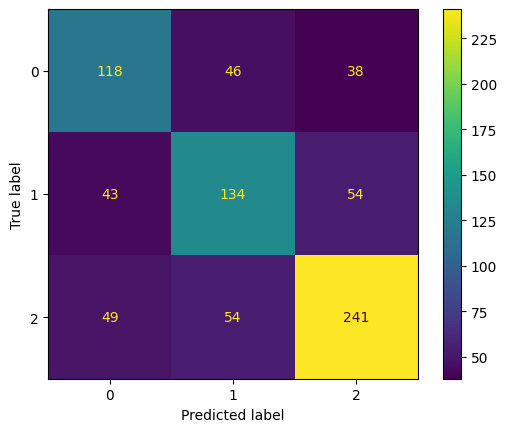

In [215]:
ConfusionMatrixDisplay.from_estimator(grid_lr.best_estimator_, X_test_vectorized, y_test)
plt.show()

SGDClassifier
---

In [216]:
from sklearn.linear_model import SGDClassifier

sgd_param_grid = {
    'penalty': ['elasticnet'],
    'alpha': [0.0005,0.001],
    'l1_ratio': [0.9,1],
    'class_weight': ['balanced'],
    'max_iter': [1000],
    'epsilon': [0.1],
    'tol' : [0.001, 0.01]
    
}

sgd_model = SGDClassifier(random_state=42)
grid_sgd = GridSearchCV(sgd_model, sgd_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_sgd.fit(X_train_vectorized, y_train)

print(grid_sgd.best_score_)
print(grid_sgd.best_params_)

0.6303011945259953
{'alpha': 0.0005, 'class_weight': 'balanced', 'epsilon': 0.1, 'l1_ratio': 1, 'max_iter': 1000, 'penalty': 'elasticnet', 'tol': 0.001}


In [217]:
print(classification_report(y_test, grid_sgd.predict(X_test_vectorized)))

              precision    recall  f1-score   support

           0       0.57      0.58      0.57       202
           1       0.56      0.59      0.57       231
           2       0.74      0.70      0.72       344

    accuracy                           0.64       777
   macro avg       0.62      0.62      0.62       777
weighted avg       0.64      0.64      0.64       777



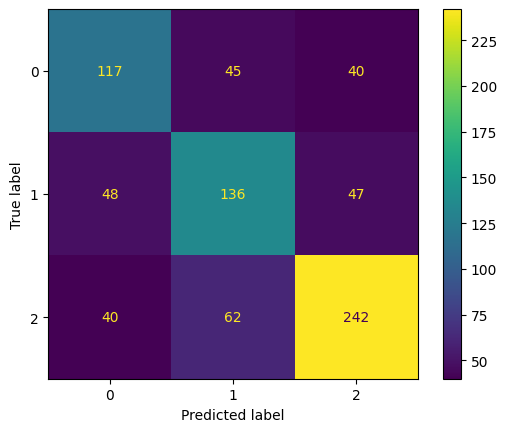

In [218]:
ConfusionMatrixDisplay.from_estimator(grid_sgd.best_estimator_, X_test_vectorized, y_test)
plt.show()

RandomForestClassifier
---

In [219]:
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {
    'n_estimators': [150],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
    'class_weight': ['balanced'],
}

rf_model = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_vectorized, y_train)

print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.6203333488668313
{'class_weight': 'balanced', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}


In [220]:
print(classification_report(y_test, grid_rf.predict(X_test_vectorized)))

              precision    recall  f1-score   support

           0       0.54      0.56      0.55       202
           1       0.54      0.58      0.56       231
           2       0.73      0.68      0.70       344

    accuracy                           0.62       777
   macro avg       0.60      0.61      0.60       777
weighted avg       0.62      0.62      0.62       777



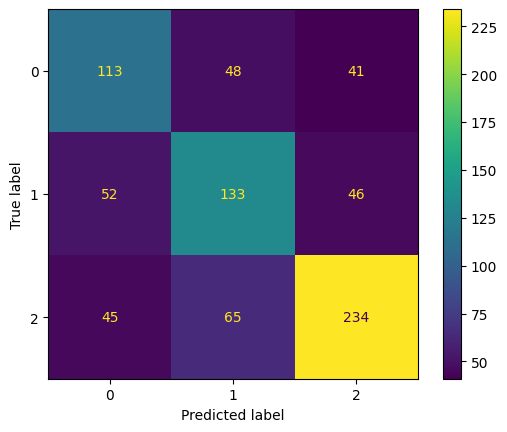

In [221]:
ConfusionMatrixDisplay.from_estimator(grid_rf.best_estimator_, X_test_vectorized, y_test)

交叉驗證-2
---

In [222]:
models = [
            grid_svc.best_estimator_, 
            grid_lr.best_estimator_, 
            grid_sgd.best_estimator_,
            grid_rf.best_estimator_
        ]
for model in models:
    print(cross_val_score(model, X_train_vectorized, y_train, cv=5).mean())

0.6036006648337139
0.6364167326840332
0.6303011945259953
0.6203333488668313


predicted_topic

In [226]:
# 使用所有模型對 X_test_vectorized 進行預測並顯示準確率
from sklearn.metrics import accuracy_score
for model in models:
    y_pred = model.predict(X_test_vectorized)
    print(f"{model.__class__.__name__} accuracy: {accuracy_score( y_test,y_pred )}")

LinearSVC accuracy: 0.6267696267696268
LogisticRegression accuracy: 0.6344916344916345
SGDClassifier accuracy: 0.637065637065637
RandomForestClassifier accuracy: 0.6177606177606177


In [227]:
X_all_tokens = [normalize_spacy(text) for text in df_copy["text"]]
X_all_vectorized = [dictionary.doc2bow(text) for text in X_all_tokens]
X_all_dense = bow_to_dense(X_all_vectorized, dictionary)

# 預測
y_all_pred = grid_lr.predict(X_all_dense)

# 加入欄位
df_copy["predicted_topic"] = y_all_pred



In [228]:
df_copy[["text", "topic", "predicted_topic"]].head(10)

,text,topic,predicted_topic
0,Why are there always trivial matters in life t...,1,2
1,"After celebrating my 21st birthday, I truly fe...",2,2
2,"In the coming March, my work pressure will be ...",2,2
3,"Indeed, the pressure of writing papers now is ...",0,0
4,"I can't learn it anymore, so let's just give u...",0,2
5,Staying up late is irreparable damage. I've st...,0,0
6,Watching decompressing videos on Douyin increa...,2,1
7,The pressure from scrolling through Xiaohongsh...,2,1
8,I'm out of money... the baby clothing store is...,1,0
9,"I am currently feeling the pressure from ez, a...",2,1


In [230]:
print(classification_report(df_copy["topic"], df_copy["predicted_topic"]))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1008
           1       0.74      0.59      0.66      1156
           2       0.75      0.79      0.77      1721

    accuracy                           0.71      3885
   macro avg       0.71      0.70      0.70      3885
weighted avg       0.71      0.71      0.71      3885

